### (a) Download Data

Package imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Get the Vertebral Column Data Set

In [2]:
df = pd.read_csv('../data/vertebral_column_data/column_2C.dat', names=["pelvic incidence", "pelvic tilt", "lumbar lordpsis angle", "sacral slope", "pelvic radius", "grade of spondylolisthisis", "class"], delimiter=' ')
df.dropna(inplace=True)
df.loc[(df["class"] == "AB"), "class"] = 1
df.loc[(df["class"] == "NO"), "class"] = 0
df.head()

,pelvic incidence,pelvic tilt,lumbar lordpsis angle,sacral slope,pelvic radius,grade of spondylolisthisis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,1
1,39.06,10.06,25.02,29.00,114.41,4.56,1
2,68.83,22.22,50.09,46.61,105.99,-3.53,1
3,69.30,24.65,44.31,44.64,101.87,11.21,1
4,49.71,9.65,28.32,40.06,108.17,7.92,1


### (b) Pre-Processing and Exploratory Data Analysis

#### i. Scatterplots

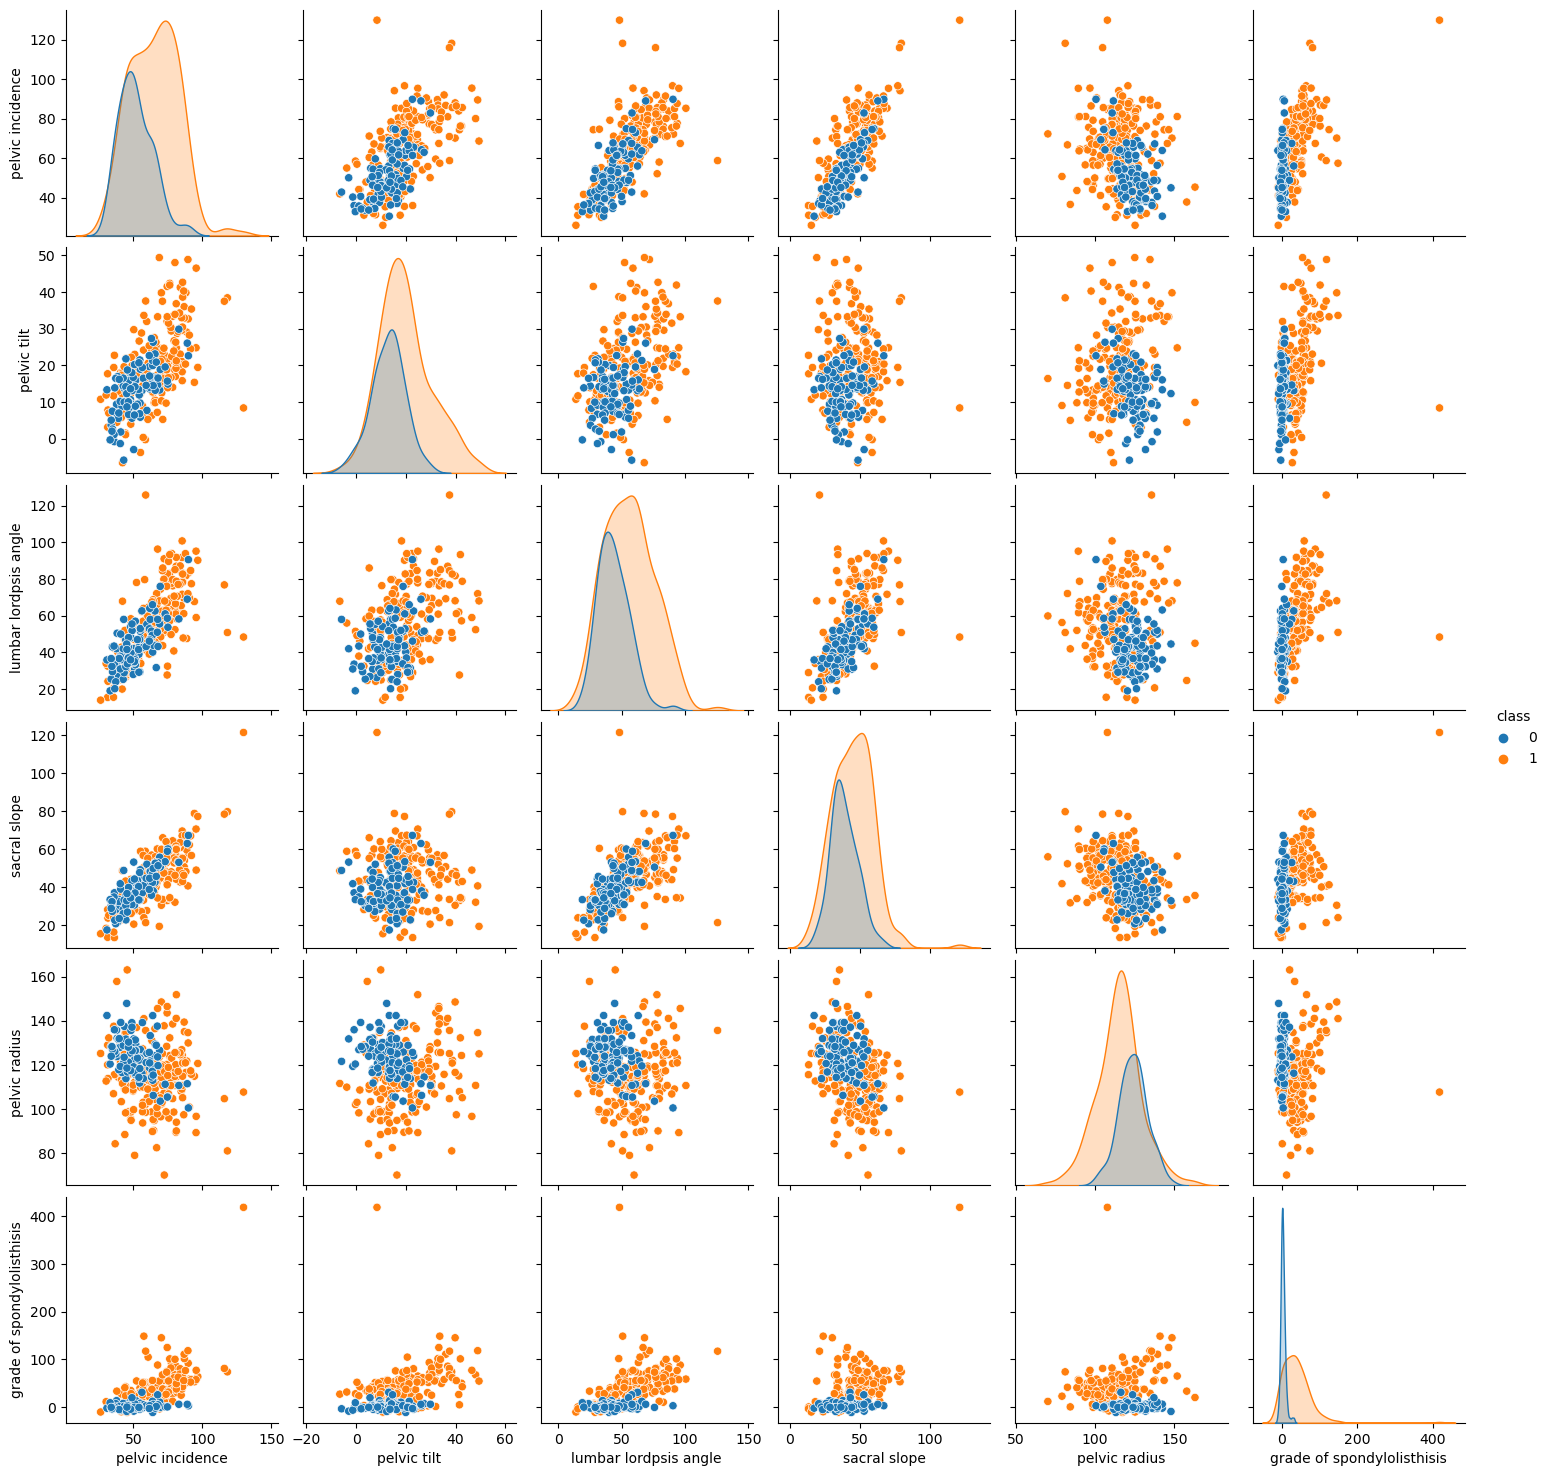

In [3]:
sns.pairplot(df, hue="class")

#### ii. Boxplots

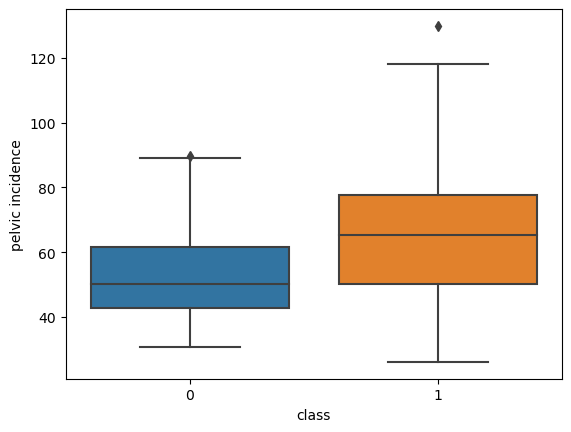

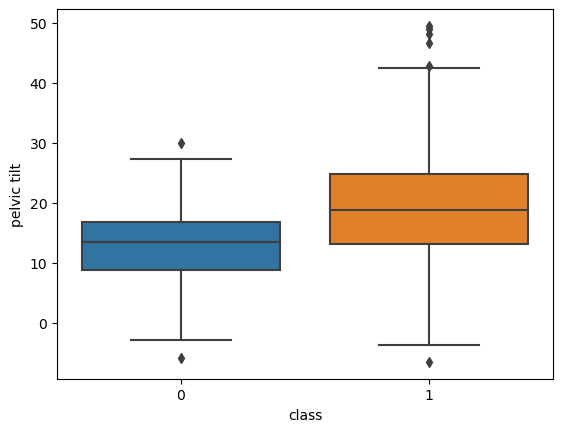

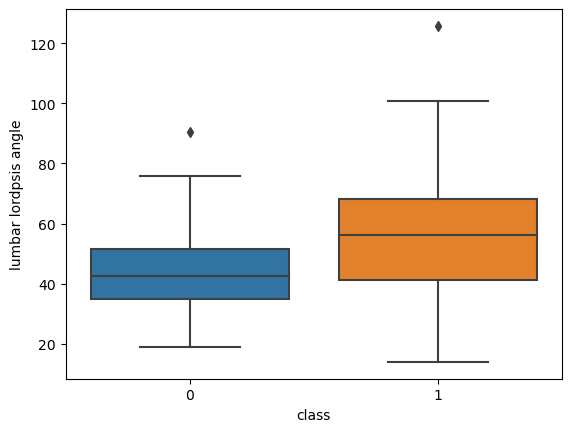

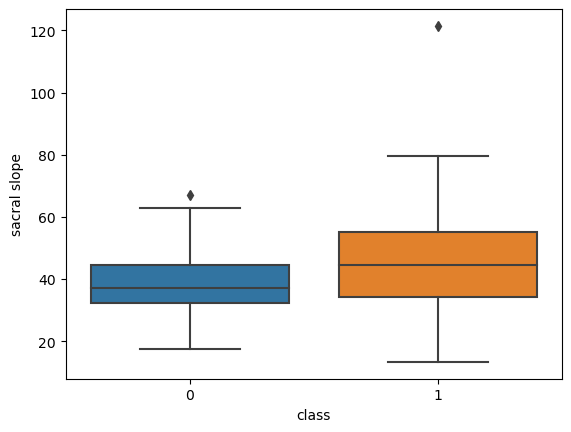

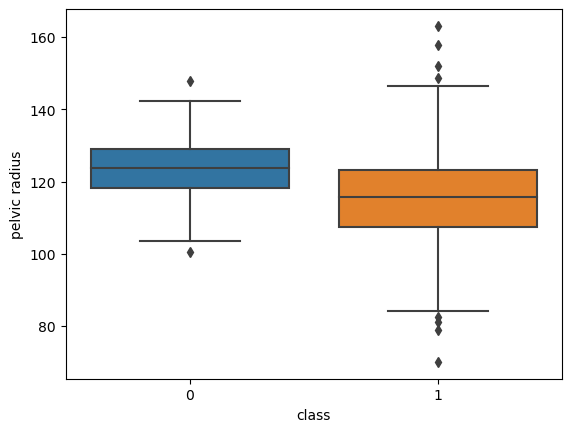

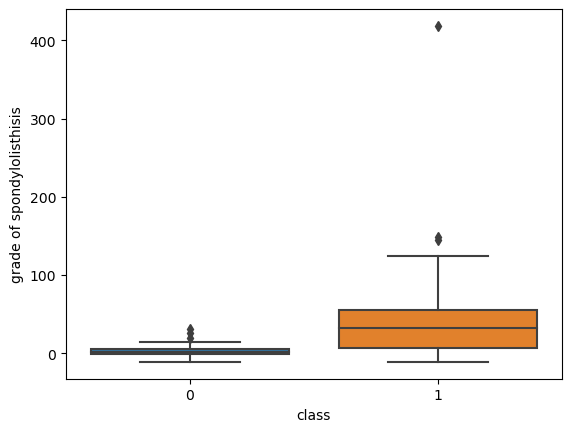

In [4]:
vars = ["pelvic incidence", "pelvic tilt", "lumbar lordpsis angle", "sacral slope", "pelvic radius", "grade of spondylolisthisis"]
for var in vars:
    sns.boxplot(data=df, x="class", y=var)
    plt.show()

#### iii. Split Data Set

In [5]:
from sklearn import preprocessing
from sklearn import utils
# Seperate two class to split data
df_0 = df.loc[df["class"] == 0]
df_1 = df.loc[df["class"] == 1]
train_0 = df_0.drop(["class"], axis=1)
label_0 = df_0["class"]
train_1 = df_1.drop(["class"], axis=1)
label_1 = df_1["class"]
train_0_data, test_0_data, train_0_label, test_0_label = train_test_split(train_0, label_0, train_size=70, random_state=0)
train_1_data, test_1_data, train_1_label, test_1_label = train_test_split(train_1, label_1, train_size=140, random_state=0)

# Concat to one dataset and shuffle it
train_data = pd.concat([train_0_data, train_1_data])
test_data = pd.concat([test_0_data, test_1_data])
train_label = pd.concat([train_0_label, train_1_label])
test_label = pd.concat([test_0_label, test_1_label])
train_data["label"] = train_label
test_data["label"] = test_label
train = train_data.sample(frac=1, random_state=0)
test = test_data.sample(frac=1, random_state=0)

# Seperate data and labels
Y_train = train["label"].to_numpy()
X_train = train.drop(["label"], axis=1).to_numpy()
Y_test = test["label"].to_numpy()
X_test = test.drop(["label"], axis=1).to_numpy()

# Convert label type
lab = preprocessing.LabelEncoder()
Y_train = lab.fit_transform(Y_train)
Y_test = lab.fit_transform(Y_test)

### (c) Classification

#### i. Euclidean Metric

In [6]:
# When p = 2, it's using euclidean_distance
kNN_model = KNeighborsClassifier(p = 2)

#### ii. Test Data

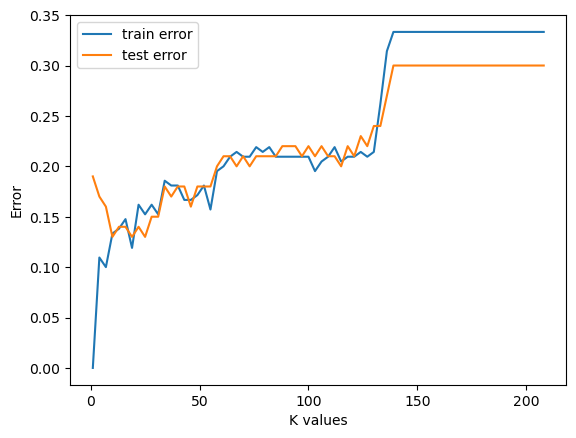

The best Euclidean metric's k value is:  10
The best Euclidean metric's error is:  0.13


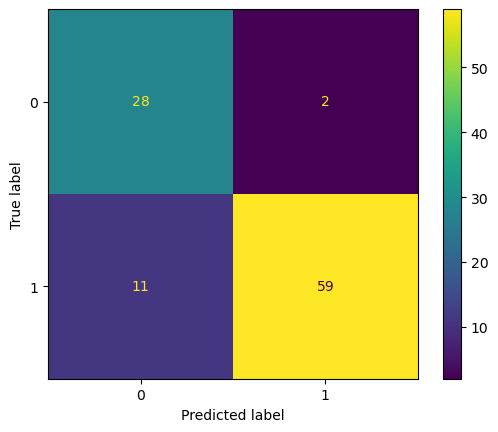

True positive rate:  0.8428571428571429
True negative rate:  0.9333333333333333
Precision:  0.9672131147540983
F1 score:  0.9007633587786258


In [7]:
def calculate_result(cur_confusion_matrix):
    tn, fp, fn, tp = cur_confusion_matrix
    acc = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 / ((1 / precision) + (1 / recall))
    return acc, precision, recall, f1

train_error = []
test_error = []
best_eu_train_error = None
best_k = None
best_confusion_matrix = None
best_error = float('inf')

k_values = [n for n in range(208, 0, -3)]
for k in k_values:
    kNN_model = KNeighborsClassifier(p = 2, n_neighbors = k)
    kNN_model.fit(X_train, Y_train)
    predictions_train = kNN_model.predict(X_train)
    cur_confusion_matrix = confusion_matrix(Y_train, predictions_train).ravel()
    acc_train, precision_train, recall_train, f1_train = calculate_result(cur_confusion_matrix)
    train_error.append(1 - acc_train)

    predictions_test = kNN_model.predict(X_test)
    cur_confusion_matrix = confusion_matrix(Y_test, predictions_test).ravel()
    acc_test, precision_test, recall_test, f1_test = calculate_result(cur_confusion_matrix)
    test_error.append(1 - acc_test)
    if (1 - acc_test) <= best_error:
        best_error = 1 - acc_test
        best_k, best_confusion_matrix = k, cur_confusion_matrix
best_eu_train_error = min(train_error)    

plt.plot(k_values, train_error, label='train error')
plt.plot(k_values, test_error, label='test error')
plt.legend(loc='best')
plt.xlabel('K values')
plt.ylabel('Error')
plt.show()

print("The best Euclidean metric's k value is: ", best_k)
print("The best Euclidean metric's error is: ", best_error)
disp = ConfusionMatrixDisplay(confusion_matrix=best_confusion_matrix.reshape((2, 2)), display_labels=kNN_model.classes_)
disp.plot()
plt.show()
tn, fp, fn, tp = best_confusion_matrix
acc, precision, recall, f1 = calculate_result(best_confusion_matrix)
print("True positive rate: ", tp / (tp + fn))
print("True negative rate: ", tn / (tn + fp))
print("Precision: ", precision)
print("F1 score: ", f1)


#### iii. Learning Curve

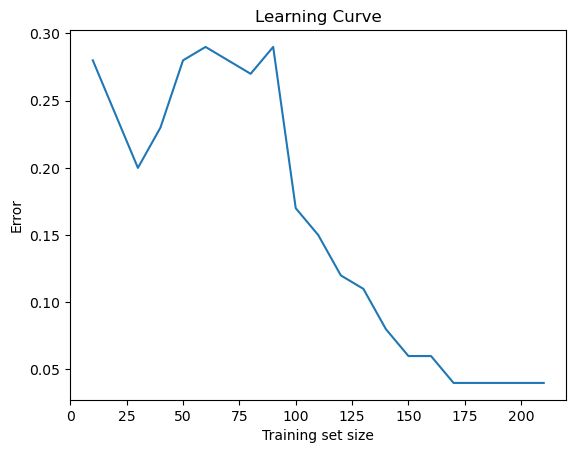

In [8]:
training_size = [n for n in range(10, 211, 10)]
errors = []

for num in training_size:
    min_error = float('inf')
    # Prepare dataset
    cur_class_0 = df_0[:num // 3]
    cur_class_1 = df_1[:num - num // 3]
    cur_data = pd.concat([cur_class_0, cur_class_1])
    cur_data = cur_data.sample(frac=1, random_state=0)
    cur_Y_train = cur_data["class"].to_numpy()
    cur_X_train = cur_data.drop(["class"], axis=1).to_numpy()
    cur_Y_train = lab.fit_transform(cur_Y_train)

    cur_k_values = [k for k in range(1, num + 1, 5)]
    for k in cur_k_values:
        kNN_model = KNeighborsClassifier(p = 2, n_neighbors = k)
        kNN_model.fit(cur_X_train, cur_Y_train)
        predictions_test = kNN_model.predict(X_test)
        cur_confusion_matrix = confusion_matrix(Y_test, predictions_test).ravel()
        acc_test, precision_test, recall_test, f1_test = calculate_result(cur_confusion_matrix)
        if 1 - acc_test <= min_error:
            min_error = 1 - acc_test
    errors.append(min_error)

plt.plot(training_size, errors)
plt.title("Learning Curve")
plt.ylabel('Error')
plt.xlabel('Training set size')
plt.show()
    

### (d) Other Metrics

#### i. Minkowski Distance.

##### A. Manhattan Distance with p = 1.

The best Manhattan Distance's k value is:  31
The best Manhattan Distance's error is:  0.15000000000000002


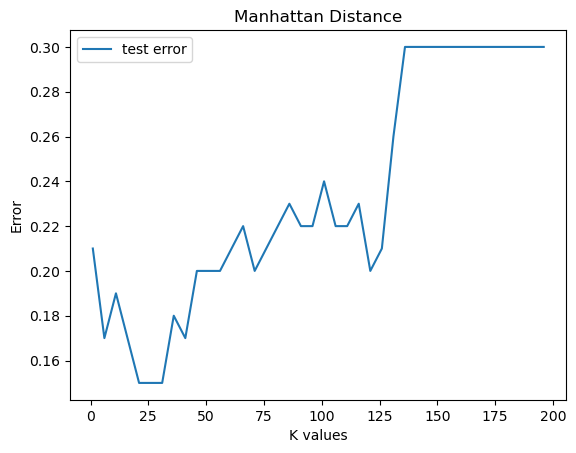

In [9]:
k_values = [x for x in range(1, 197 ,5)]
train_manhattan_error = []
test_manhattan_error = []
best_ma_train_error = None
best_manhattan_k = None
best_manhattan_error = float('inf')

for k in k_values:
    kNN_model = KNeighborsClassifier(p = 1, n_neighbors = k)
    kNN_model.fit(X_train, Y_train)
    predictions_train = kNN_model.predict(X_train)
    cur_confusion_matrix = confusion_matrix(Y_train, predictions_train).ravel()
    acc_test, precision_test, recall_test, f1_test = calculate_result(cur_confusion_matrix)
    train_manhattan_error.append(1 - acc_test)
    
    predictions_test = kNN_model.predict(X_test)
    cur_confusion_matrix = confusion_matrix(Y_test, predictions_test).ravel()
    acc_test, precision_test, recall_test, f1_test = calculate_result(cur_confusion_matrix)
    test_manhattan_error.append(1 - acc_test)
    if (1 - acc_test) <= best_manhattan_error:
        best_manhattan_error = 1 - acc_test
        best_manhattan_k = k

best_ma_train_error = min(train_manhattan_error)

print("The best Manhattan Distance's k value is: ", best_manhattan_k)
print("The best Manhattan Distance's error is: ", best_manhattan_error)
plt.plot(k_values, test_manhattan_error, label='test error')
plt.legend(loc='best')
plt.xlabel('K values')
plt.ylabel('Error')
plt.title("Manhattan Distance")
plt.show()

##### B. With log10(p) in {0.1, 0.2, 0.3, ... ,1}.

The best log(p) is:  0.6


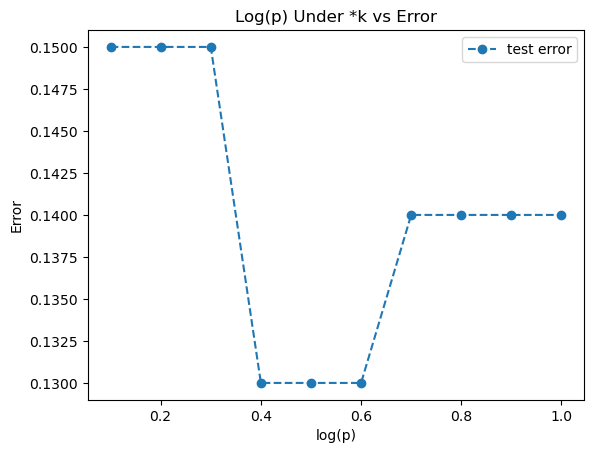

In [10]:
log_ps = np.arange(0.1, 1.1, 0.1)
best_p_error = float('inf')
best_log_p = None
test_p_error = []
for i, lop_p in enumerate(log_ps):
    cur_p = pow(10, lop_p)
    kNN_model = KNeighborsClassifier(p = cur_p, n_neighbors = best_manhattan_k)
    kNN_model.fit(X_train, Y_train)
    predictions_test = kNN_model.predict(X_test)
    cur_confusion_matrix = confusion_matrix(Y_test, predictions_test).ravel()
    acc_test, precision_test, recall_test, f1_test = calculate_result(cur_confusion_matrix)
    test_p_error.append(1 - acc_test)
    if (1 - acc_test) <= best_p_error:
        best_p_error = 1 - acc_test
        best_log_p = round(lop_p, 1)

print("The best log(p) is: ", best_log_p)
plt.plot(log_ps, test_p_error, '--o', label='test error')
plt.legend(loc='best')
plt.xlabel('log(p)')
plt.ylabel('Error')
plt.title("Log(p) Under *k vs Error")
plt.show()
    

##### C. Chebyshev Distance With p -> infinity.

The best Chebyshev Distance's k value is:  11
The best Chebyshev Distance's error is:  0.10999999999999999


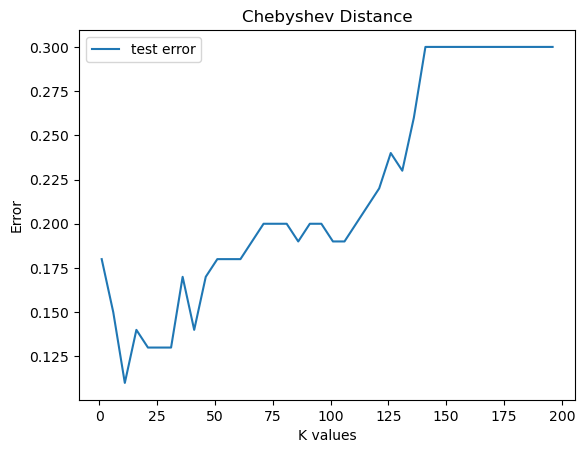

In [11]:
best_ch_train_error = None
best_chebyshev_k = None
best_chebyshev_error = float('inf')
train_chebyshev_errors = []
test_chebyshev_errors = []

for k in k_values:
    kNN_model = KNeighborsClassifier(p = float('inf'), n_neighbors = k)
    kNN_model.fit(X_train, Y_train)
    predictions_train = kNN_model.predict(X_train)
    cur_confusion_matrix = confusion_matrix(Y_train, predictions_train).ravel()
    acc_test, precision_test, recall_test, f1_test = calculate_result(cur_confusion_matrix)
    train_chebyshev_errors.append(1 - acc_test)

    predictions_test = kNN_model.predict(X_test)
    cur_confusion_matrix = confusion_matrix(Y_test, predictions_test).ravel()
    acc_test, precision_test, recall_test, f1_test = calculate_result(cur_confusion_matrix)
    test_chebyshev_errors.append(1 - acc_test)
    if (1 - acc_test) <= best_chebyshev_error:
        best_chebyshev_error = 1 - acc_test
        best_chebyshev_k = k
        
best_ch_train_error = min(train_chebyshev_errors)

print("The best Chebyshev Distance's k value is: ", best_chebyshev_k)
print("The best Chebyshev Distance's error is: ", best_chebyshev_error)
plt.plot(k_values, test_chebyshev_errors, label='test error')
plt.legend(loc='best')
plt.xlabel('K values')
plt.ylabel('Error')
plt.title("Chebyshev Distance")
plt.show()

#### ii. Mahalanobis Distance.

The best Mahalanobis Distance's k value is:  21
The best Mahalanobis Distance's error is:  0.12


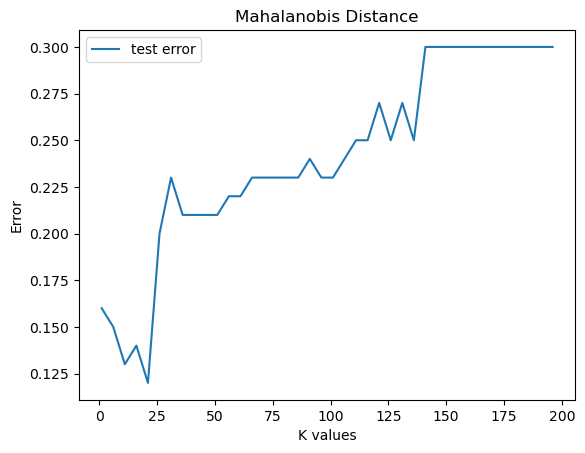

In [12]:
best_mahalanobis_train_error = None
best_mahalanobis_k = None
best_mahalanobis_error = float('inf')
train_mahalanobis_errors = []
test_mahalanobis_errors = []

for k in k_values:
    kNN_model = KNeighborsClassifier(metric='mahalanobis', metric_params={'VI': np.cov(X_train, rowvar=False)}, n_neighbors = k)
    kNN_model.fit(X_train, Y_train)
    predictions_train = kNN_model.predict(X_train)
    cur_confusion_matrix = confusion_matrix(Y_train, predictions_train).ravel()
    acc_test, precision_test, recall_test, f1_test = calculate_result(cur_confusion_matrix)
    train_mahalanobis_errors.append(1 - acc_test)

    predictions_test = kNN_model.predict(X_test)
    cur_confusion_matrix = confusion_matrix(Y_test, predictions_test).ravel()
    acc_test, precision_test, recall_test, f1_test = calculate_result(cur_confusion_matrix)
    test_mahalanobis_errors.append(1 - acc_test)
    if (1 - acc_test) <= best_mahalanobis_error:
        best_mahalanobis_error = 1 - acc_test
        best_mahalanobis_k = k

best_mahalanobis_train_error = min(train_mahalanobis_errors)

print("The best Mahalanobis Distance's k value is: ", best_mahalanobis_k)
print("The best Mahalanobis Distance's error is: ", best_mahalanobis_error)
plt.plot(k_values, test_mahalanobis_errors, label='test error')
plt.legend(loc='best')
plt.xlabel('K values')
plt.ylabel('Error')
plt.title("Mahalanobis Distance")
plt.show()

### Summarize the test errors in a table

In [13]:
result = {'Distance Metric':  ['Manhattan', 'Chebyshev', 'Mahalanobis'],
        'Best Test Error': [best_manhattan_error, best_chebyshev_error, best_mahalanobis_error],
        'Best K Value': [best_manhattan_k, best_chebyshev_k, best_mahalanobis_k]
        }
table = pd.DataFrame(result)
table.head()

,Distance Metric,Best Test Error,Best K Value
0,Manhattan,0.15,31
1,Chebyshev,0.11,11
2,Mahalanobis,0.12,21


### (e) Weighted Decision

The best weighted Euclidean Distance's k value is:  161
The best weighted Euclidean Distance's error is:  0.10999999999999999


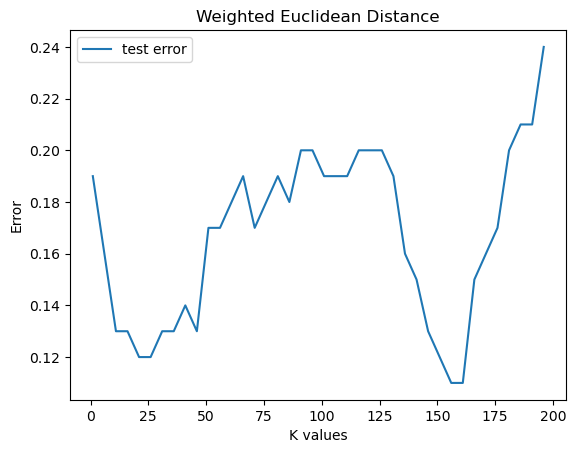

In [14]:
# Euclidean
train_we_euclidean_errors = []
test_euclidean_errors = []
best_we_eu_train_error = None
best_euclidean_k = None
best_euclidean_error = float('inf')

for k in k_values:
    kNN_model = KNeighborsClassifier(p = 2, n_neighbors = k, weights='distance')
    kNN_model.fit(X_train, Y_train)
    predictions_train = kNN_model.predict(X_train)
    cur_confusion_matrix = confusion_matrix(Y_train, predictions_train).ravel()
    acc_test, precision_test, recall_test, f1_test = calculate_result(cur_confusion_matrix)
    train_we_euclidean_errors.append(1 - acc_test)

    predictions_test = kNN_model.predict(X_test)
    cur_confusion_matrix = confusion_matrix(Y_test, predictions_test).ravel()
    acc_test, precision_test, recall_test, f1_test = calculate_result(cur_confusion_matrix)
    test_euclidean_errors.append(1 - acc_test)
    if (1 - acc_test) <= best_euclidean_error:
        best_euclidean_error = 1 - acc_test
        best_euclidean_k = k

best_we_eu_train_error = min(train_we_euclidean_errors)

print("The best weighted Euclidean Distance's k value is: ", best_euclidean_k)
print("The best weighted Euclidean Distance's error is: ", best_euclidean_error)
plt.plot(k_values, test_euclidean_errors, label='test error')
plt.legend(loc='best')
plt.xlabel('K values')
plt.ylabel('Error')
plt.title("Weighted Euclidean Distance")
plt.show()

The best weighted Manhattan Distance's k value is:  161
The best weighted Manhattan Distance's error is:  0.14


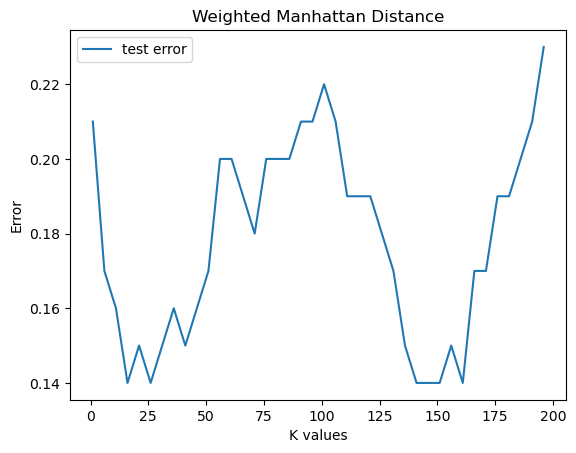

In [15]:
# Manhattan
train_we_manhattan_error = []
test_manhattan_error = []
best_we_ma_train_error = None
best_manhattan_k = None
best_manhattan_error = float('inf')

for k in k_values:
    kNN_model = KNeighborsClassifier(p = 1, n_neighbors = k, weights='distance')
    kNN_model.fit(X_train, Y_train)
    predictions_train = kNN_model.predict(X_train)
    cur_confusion_matrix = confusion_matrix(Y_train, predictions_train).ravel()
    acc_test, precision_test, recall_test, f1_test = calculate_result(cur_confusion_matrix)
    train_we_manhattan_error.append(1 - acc_test)

    predictions_test = kNN_model.predict(X_test)
    cur_confusion_matrix = confusion_matrix(Y_test, predictions_test).ravel()
    acc_test, precision_test, recall_test, f1_test = calculate_result(cur_confusion_matrix)
    test_manhattan_error.append(1 - acc_test)
    if (1 - acc_test) <= best_manhattan_error:
        best_manhattan_error = 1 - acc_test
        best_manhattan_k = k

best_we_ma_train_error = min(train_we_manhattan_error)

print("The best weighted Manhattan Distance's k value is: ", best_manhattan_k)
print("The best weighted Manhattan Distance's error is: ", best_manhattan_error)
plt.plot(k_values, test_manhattan_error, label='test error')
plt.legend(loc='best')
plt.xlabel('K values')
plt.ylabel('Error')
plt.title("Weighted Manhattan Distance")
plt.show()

The best weighted Chebyshev Distance's k value is:  26
The best weighted Chebyshev Distance's error is:  0.10999999999999999


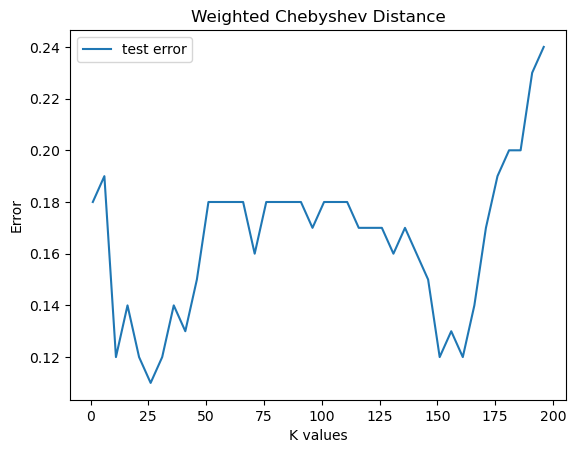

In [16]:
# Chebyshev
best_we_ch_train_error = None
best_chebyshev_k = None
best_chebyshev_error = float('inf')
train_we_chebyshev_errors = []
test_chebyshev_errors = []

for k in k_values:
    kNN_model = KNeighborsClassifier(p = float('inf'), n_neighbors = k, weights='distance')
    kNN_model.fit(X_train, Y_train)
    predictions_train = kNN_model.predict(X_train)
    cur_confusion_matrix = confusion_matrix(Y_train, predictions_train).ravel()
    acc_test, precision_test, recall_test, f1_test = calculate_result(cur_confusion_matrix)
    train_we_chebyshev_errors.append(1 - acc_test)

    predictions_test = kNN_model.predict(X_test)
    cur_confusion_matrix = confusion_matrix(Y_test, predictions_test).ravel()
    acc_test, precision_test, recall_test, f1_test = calculate_result(cur_confusion_matrix)
    test_chebyshev_errors.append(1 - acc_test)
    if (1 - acc_test) <= best_chebyshev_error:
        best_chebyshev_error = 1 - acc_test
        best_chebyshev_k = k
best_we_ch_train_error = min(train_we_chebyshev_errors)

print("The best weighted Chebyshev Distance's k value is: ", best_chebyshev_k)
print("The best weighted Chebyshev Distance's error is: ", best_chebyshev_error)
plt.plot(k_values, test_chebyshev_errors, label='test error')
plt.legend(loc='best')
plt.xlabel('K values')
plt.ylabel('Error')
plt.title("Weighted Chebyshev Distance")
plt.show()

In [17]:
result = {'Distance Metric':  ['Euclidean', 'Manhattan', 'Chebyshev'],
        'Best Test Error': [best_euclidean_error, best_manhattan_error, best_chebyshev_error],
        'Best K Value': [best_euclidean_k, best_manhattan_k, best_chebyshev_k]
        }
table = pd.DataFrame(result)
table.head()

,Distance Metric,Best Test Error,Best K Value
0,Euclidean,0.11,161
1,Manhattan,0.14,161
2,Chebyshev,0.11,26


### (f) Training Error Rate

In [18]:
result = {'KNN Method':  ['Euclidean', 'Manhattan', 'Chebyshev', 'Mahalanobis', 'Weighted Euclidean', 'Weighted Manhattan', 'Weighted Chebyshev'],
        'Best Train Error': [best_eu_train_error, best_ma_train_error, best_ch_train_error, best_mahalanobis_train_error, best_we_eu_train_error, best_we_ma_train_error, best_we_ch_train_error]
        }
table = pd.DataFrame(result)
table

,KNN Method,Best Train Error
0,Euclidean,0.0
1,Manhattan,0.0
2,Chebyshev,0.0
3,Mahalanobis,0.0
4,Weighted Euclidean,0.0
5,Weighted Manhattan,0.0
6,Weighted Chebyshev,0.0
